In [1]:
import sys
sys.path.insert(0, '/home/xp/stereo_toolbox/')

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
torch.backends.cudnn.benchmark = True
import matplotlib.pyplot as plt
import argparse

# auto reload modules
%load_ext autoreload
%autoreload 2

from stereo_toolbox.datasets import *
from stereo_toolbox.models import *
from stereo_toolbox.visualization import *
from stereo_toolbox.evaluation import *
from stereo_toolbox.loss_functions import *

/home/xp/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import kornia.filters as filters

"""
PSMNet all: 0.1826 edge: 0.4664 non_edge: 0.1698
GwcNet all: 0.1413 edge: 0.4193 non_edge: 0.1285
PCWNet: all: 0.1878 edge: 0.4130 non_edge: 0.1773

"""

device = 'cuda:3'
model = load_checkpoint_flexible(PCWNet_GC(),
                                 '/home/xp/stereo_project/distill/checkpoint/SceneFlow/pretrained_models/PCWNet_1.tar',
                                 'state_dict')
model.to(device).eval()

dataset = SceneFlow_Dataset(split='test_finalpass', training=False)
dataloader = DataLoader(dataset, batch_size=1)

MM_all = []
MM_edge = []
MM_non_edge = []


dataloader = tqdm(dataloader)
for i, data in enumerate(dataloader):
    left, right = data['left'].to(device), data['right'].to(device)
    disp = data['gt_disp'].to(device)

    if (disp > 0).sum() == 0:
        continue

    colored_disp = colored_disparity_map_Spectral_r(data['gt_disp'][0])

    edge = filters.sobel(disp.unsqueeze(1)) > 1
    # Perform 3x3 convolution dilation on the boolean edge tensor
    kernel = torch.ones((1, 1, 3, 3), device=device)
    dilated_edges = (F.conv2d(edge.float(), kernel, padding=1) > 0).squeeze()

    # plt.imshow(colored_disp)
    # plt.show()
    # plt.imshow(edge.cpu().numpy().squeeze())
    # plt.show()
    # plt.imshow(dilated_edges.cpu().numpy().squeeze())
    # plt.show()
    
    B, C, H, W = left.shape

    with torch.no_grad():
        x = model(left, right)

    _, mode_mask = split_mode(x)
    x = x * ~mode_mask

    mm_mask = (x > 0.02).any(dim=1).squeeze()
    mm_edge = mm_mask * edge
    mm_non_edge = mm_mask * ~edge.squeeze()

    MM_all.append(mm_mask.float().mean().item())
    MM_edge.append((mm_edge.float().mean() / (edge).float().mean()).item())
    MM_non_edge.append((mm_non_edge.float().mean() / (~edge).float().mean()).item())

    dataloader.set_description(f"all: {np.array(MM_all).mean():.4f} edge: {np.array(MM_edge).mean():.4f} non_edge: {np.array(MM_non_edge).mean():.4f}")

In [4]:
from matplotlib.patches import RegularPolygon


device = 'cuda:3'
model = load_checkpoint_flexible(PSMNet(),
                                 '/home/xp/stereo_project/distill/checkpoint/SceneFlow/pretrained_models/PSMNet_1.tar',
                                 'state_dict')
model.to(device).eval()

PSMNet(
  (feature_extraction): feature_extraction(
    (firstconv): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ReLU(inplace=True)
      (2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): ReLU(inplace=True)
      (4): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (5): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding

In [10]:
dataset = MiddleburyEval3_Dataset(split='trainH_all', training=False)
dataloader = DataLoader(dataset, batch_size=1)
dataloader = tqdm(dataloader)
for i, data in enumerate(dataloader):
    left, right = data['left'].to(device), data['right'].to(device)
    disp = data['gt_disp'].to(device)

    raw = data['raw_left'].squeeze().numpy()

    with torch.no_grad():
        x = model(left, right)

    assert 0

  0%|          | 0/15 [00:00<?, ?it/s]/home/xp/stereo_toolbox/stereo_toolbox/models/PSMNet/submodule.py:118: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  output_branch1 = F.upsample(output_branch1, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')
/home/xp/stereo_toolbox/stereo_toolbox/models/PSMNet/submodule.py:121: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  output_branch2 = F.upsample(output_branch2, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')
/home/xp/stereo_toolbox/stereo_toolbox/models/PSMNet/submodule.py:124: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  output_branch3 = F.upsample(output_branch3, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')
/home/xp/stereo_toolbox/stereo_toolbox/models/PSMNet/submodule.py:127: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.function

AssertionError: 

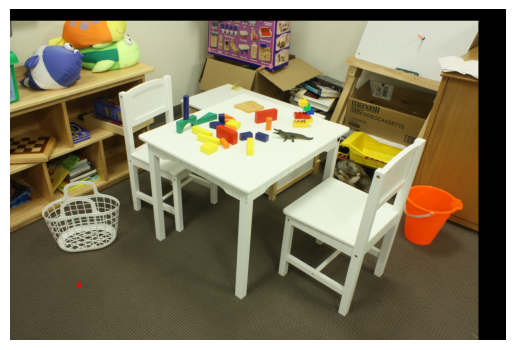

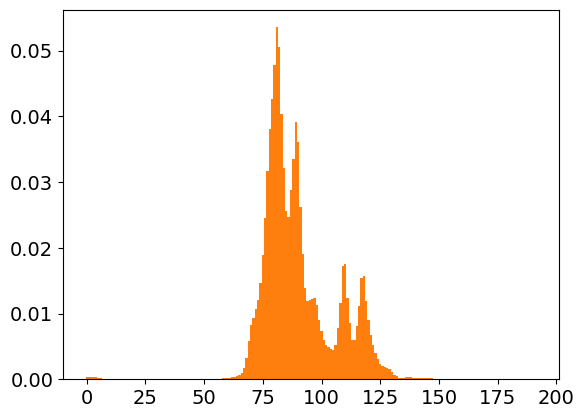

In [52]:

H= 650
W = 210

H = 800
W = 200


# H = 290
# W = 1050

plt.imshow(raw.transpose(1, 2, 0))
star = RegularPolygon((W, H), numVertices=5, radius=5, color='red', alpha=1)
plt.gca().add_patch(star)
plt.axis('off')
plt.show()

plt.bar(range(x.shape[1]), x[0, :, H, W].cpu().numpy(), width=1, color='C1')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

